In [1]:
import scipy as sp
import numpy as np
import qibo
from qibo.symbols import *
from qibo import hamiltonians
import matplotlib.pyplot as plt
from tqdm import tqdm

In [102]:
nqubits = 5
#H_def = sum([ Z(x+1)*Z(x) + X(x+1)*X(x) + Y(x+1)*Y(x) for x in range(nqubits-1)])
H_def = sum([ Z(x+1)*Z(x) for x in range(nqubits-1)])
H_def += Z(0)*Z(nqubits-1)
H = hamiltonians.SymbolicHamiltonian(H_def).matrix

[Qibo 0.2.16|WARNING|2025-02-19 17:12:24]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


In [103]:
eigs, vecs = np.linalg.eigh(H)
print(eigs)

[-3. -3. -3. -3. -3. -3. -3. -3. -3. -3.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  5.  5.]


In [104]:
def maxEntangledState(nqubits):
    """
    Returns the maximum entangled state of n qubits.
    """
    return np.array([1/np.sqrt(2**nqubits)]*(2**nqubits))

def TFD(beta, ham, state):
    """
    Returns the Thermofield double state at inverse temperature beta.
    """
    tfd = sp.linalg.expm(-beta*ham/2)@state
    normalization = np.sqrt(np.conj(tfd)@tfd)
    return 1/normalization*tfd

In [105]:
beta = np.logspace(-5, 1.8, 10)
tfd = np.zeros((len(beta), 2**nqubits), dtype=complex)
for i in range(len(beta)):
    tfd[i] = TFD(beta[i], H, maxEntangledState(nqubits))

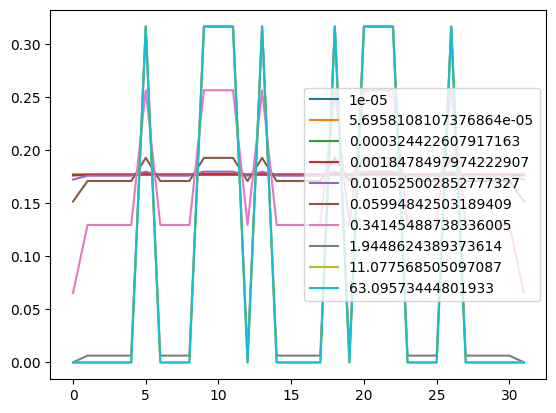

In [106]:
plt.figure()
for i in range(len(beta)):
    plt.plot(np.abs(tfd[i,:]), label=str(beta[i]))
    
plt.legend()

In [111]:
def commutator(A,B):
    """
    Commutator of two matrices A and B.
    """
    return A@B - B@A

def defaultStep(H):
    """
    Step size guaranteeing decrease $s = \frac{\Delta}{12\|H\|^3}$.
    """
    eigs = sp.linalg.eigvalsh(H)
    delta = eigs[1]-eigs[0] 
    norm = eigs[-1]
    s = delta/(12*norm**3)
    return s

def DBI(iters, H, step, state):
    """
    DBI iterations using the commutator with the Hamiltonian.
    """
    rho = np.outer(state, state.conj())
    newState = np.empty((iters+1,len(state)), dtype=complex)
    newState[0] = state
    for i in range(iters):
        rho = np.outer(newState[i], newState[i].conj())
        comm = commutator(rho, H)
        newState[i+1] = sp.linalg.expm(step*comm)@newState[i]
        newState[i+1] = newState[i+1]/np.sqrt(np.conj(newState[i+1])@newState[i+1])
    return newState

def UJFidelity(state1, state2):
    """
    Uhlmann-Josza fidelity between two states.
    """
    rho = np.outer(state1, state1.conj())
    sigma = np.outer(state2, state2.conj())
    return np.trace(sp.linalg.sqrtm(sp.linalg.sqrtm(rho)@sigma@sp.linalg.sqrtm(rho)))**2



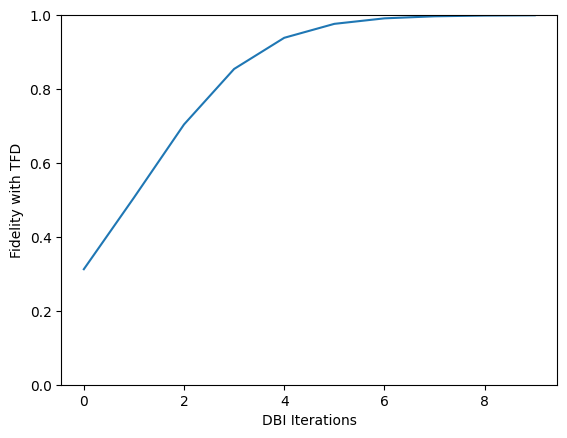

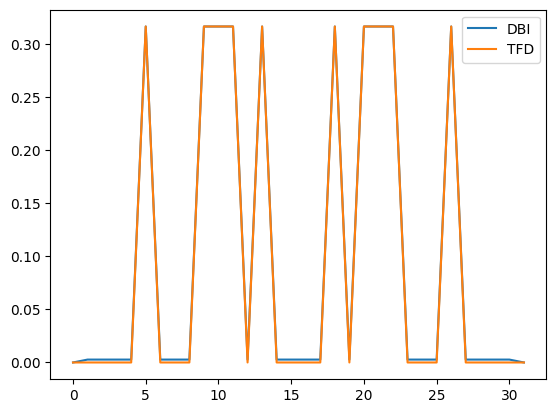

In [112]:
state = maxEntangledState(nqubits)
step = 0.1
iters = 10

newState = DBI(iters, H, step, state)

fidelity = np.zeros(iters)
for i in range(iters):
    fidelity[i] = np.abs(UJFidelity(tfd[-1,:], newState[i,:]))

plt.figure()
plt.plot(fidelity)
plt.xlabel('DBI Iterations')
plt.ylabel('Fidelity with TFD')
plt.ylim(0,1)
plt.show()


plt.figure()
plt.plot(np.abs(newState[-1,:]),label='DBI')
plt.plot(np.abs(tfd[-1,:]), label='TFD')
plt.legend()
plt.show()



In [113]:
def reflectionOperator(state, step):
    """
    Reflection operator for the DBQITE algorithm.
    """
    rho = np.outer(state, state.conj())
    return sp.linalg.expm(1j*np.sqrt(step)*rho)

def unitaryRecursion(ham, refOperator, step):
    """
    Unitary recursion for the DBQITE algorithm.
    """
    U = sp.linalg.expm(1j*np.sqrt(step)*ham) @ refOperator @ sp.linalg.expm(-1j*np.sqrt(step)*ham)
    return U

def DBQITE(iters, H, step, state):
    """
    DBQITE algorithm.
    """
    ref = reflectionOperator(state, step)
    newState = np.empty((iters+1,len(state)), dtype=complex)
    newState[0,:] = state
    for i in range(iters):
        ref = reflectionOperator(newState[i,:], step)
        U = unitaryRecursion(H, ref, step)
        newState[i+1,:] = U@newState[i,:]
        newState[i+1,:] = newState[i+1,:]/np.sqrt(np.conj(newState[i+1,:])@newState[i+1,:])
    return newState



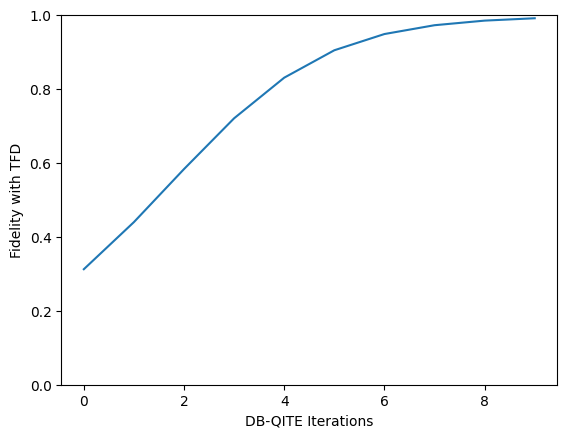

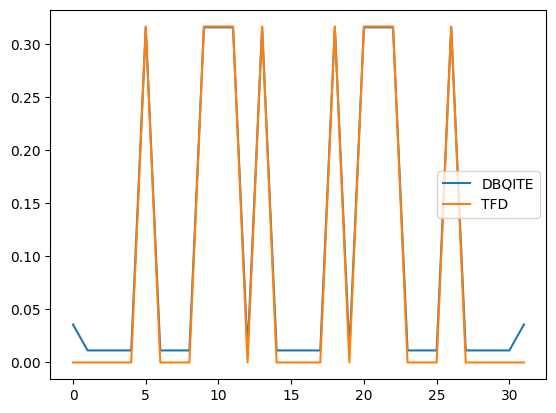

In [115]:
state = maxEntangledState(nqubits)
step = 0.1
iters = 10

newState = DBQITE(iters, H, step, state)

fidelity = np.zeros(iters)
for i in range(iters):
    fidelity[i] = np.abs(UJFidelity(tfd[-1,:], newState[i,:]))

plt.figure()
plt.plot(fidelity)
plt.xlabel('DB-QITE Iterations')
plt.ylabel('Fidelity with TFD')
plt.ylim(0,1)

plt.figure()
plt.plot(np.abs(newState[-1,:]),label='DBQITE')
plt.plot(np.abs(tfd[-1,:]), label='TFD')
plt.legend()



In [123]:
nqubits = 4
H_def = sum([X(x+1)*X(x) + Y(x+1)*Y(x) for x in range(nqubits-1)])
H = hamiltonians.SymbolicHamiltonian(H_def).matrix
eigs, vecs = np.linalg.eigh(H)
print(eigs)

[Qibo 0.2.16|WARNING|2025-02-19 17:16:39]: Calculating the dense form of a symbolic Hamiltonian. This operation is memory inefficient.


[-4.47213595 -3.23606798 -3.23606798 -2.         -1.23606798 -1.23606798
  0.          0.          0.          0.          1.23606798  1.23606798
  2.          3.23606798  3.23606798  4.47213595]


In [124]:
beta = np.logspace(-5, 1.8, 10)
tfd = np.zeros((len(beta), 2**nqubits), dtype=complex)
for i in range(len(beta)):
    tfd[i] = TFD(beta[i], H, maxEntangledState(nqubits))

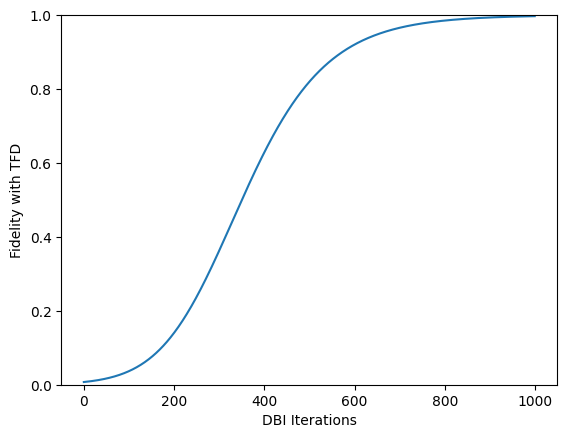

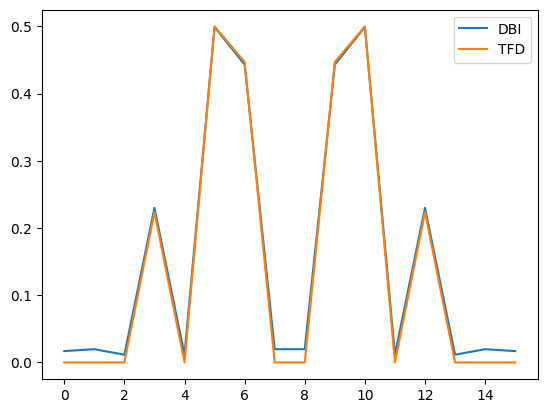

In [127]:
state = maxEntangledState(nqubits)
step = defaultStep(H)
iters = 1000

newState = DBI(iters, H, step, state)

fidelity = np.zeros(iters)
for i in range(iters):
    fidelity[i] = np.abs(UJFidelity(tfd[-1,:], newState[i,:]))

plt.figure()
plt.plot(fidelity)
plt.xlabel('DBI Iterations')
plt.ylabel('Fidelity with TFD')
plt.ylim(0,1)
plt.show()


plt.figure()
plt.plot(np.abs(newState[-1,:]),label='DBI')
plt.plot(np.abs(tfd[-1,:]), label='TFD')
plt.legend()
plt.show()

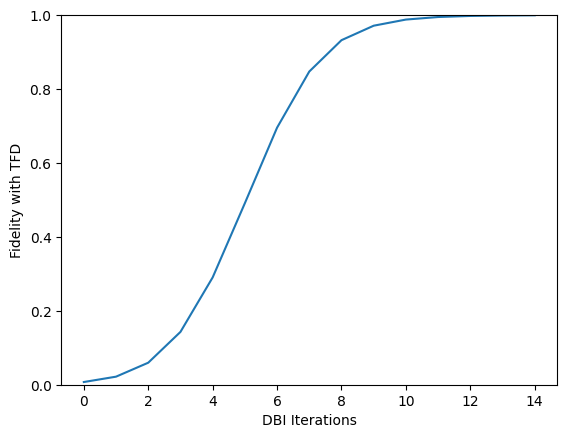

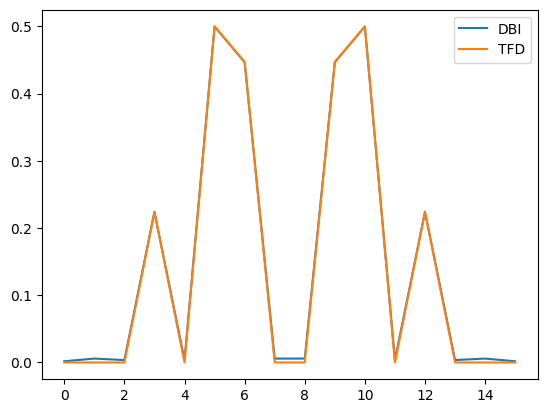

In [130]:
state = maxEntangledState(nqubits)
step = 0.1
iters = 15

newState = DBI(iters, H, step, state)

fidelity = np.zeros(iters)
for i in range(iters):
    fidelity[i] = np.abs(UJFidelity(tfd[-1,:], newState[i,:]))

plt.figure()
plt.plot(fidelity)
plt.xlabel('DBI Iterations')
plt.ylabel('Fidelity with TFD')
plt.ylim(0,1)
plt.show()


plt.figure()
plt.plot(np.abs(newState[-1,:]),label='DBI')
plt.plot(np.abs(tfd[-1,:]), label='TFD')
plt.legend()
plt.show()

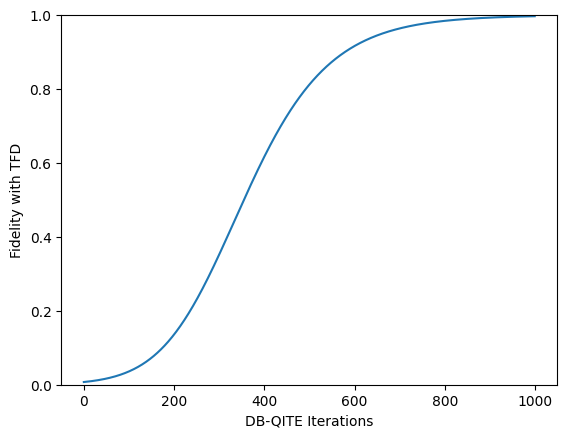

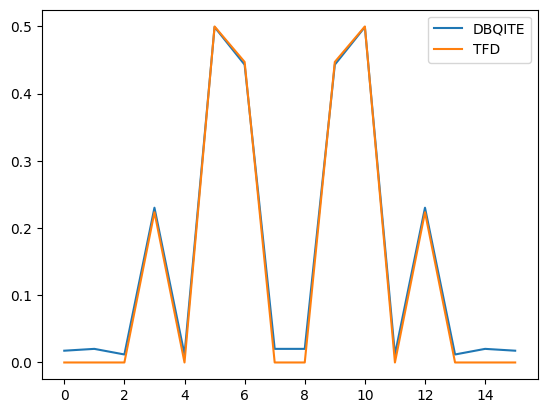

In [131]:
state = maxEntangledState(nqubits)
step = defaultStep(H)
iters = 1000

newState = DBQITE(iters, H, step, state)

fidelity = np.zeros(iters)
for i in range(iters):
    fidelity[i] = np.abs(UJFidelity(tfd[-1,:], newState[i,:]))

plt.figure()
plt.plot(fidelity)
plt.xlabel('DB-QITE Iterations')
plt.ylabel('Fidelity with TFD')
plt.ylim(0,1)

plt.figure()
plt.plot(np.abs(newState[-1,:]),label='DBQITE')
plt.plot(np.abs(tfd[-1,:]), label='TFD')
plt.legend()



In [137]:
def thermalStatePrepComparison(beta, H, nqubits, method, step = None):
    initState = maxEntangledState(nqubits)
    tfd = TFD(beta, H, initState)
    if step is None:
            step = defaultStep(H)
    iters = int(beta/(2*step))
    if method == 'DBI':
        newState = DBI(iters, H, step, initState)
    elif method == 'DBQITE':
        newState = DBQITE(iters, H, step, initState)
    # elif method == 'DBQITE-3':
    #     newState = DBQITE_thirdOrder(iters, H, step, initState)
    fidelity = np.abs(UJFidelity(tfd, newState[-1,:]))

    return fidelity

In [138]:
beta = np.logspace(-2, 1, 100)
fidelityDBI_defaultStep = np.zeros(len(beta))
fidelityDBQITE_defaultStep = np.zeros(len(beta))
fidelityDBI_smallStep = np.zeros(len(beta))
fidelityDBQITE_smallStep = np.zeros(len(beta))
# fidelityDBQITE_thirdOrder_defaultStep = np.zeros(len(beta))
# fidelityDBQITE_thirdOrder_smallStep = np.zeros(len(beta))
for i in tqdm(range(len(beta))):
    fidelityDBI_defaultStep[i] = thermalStatePrepComparison(beta[i], H, nqubits, 'DBI')
    fidelityDBQITE_defaultStep[i] = thermalStatePrepComparison(beta[i], H, nqubits, 'DBQITE')
    fidelityDBI_smallStep[i] = thermalStatePrepComparison(beta[i], H, nqubits, 'DBI', step = 0.01)
    fidelityDBQITE_smallStep[i] = thermalStatePrepComparison(beta[i], H, nqubits, 'DBQITE', step = 0.01)
    # fidelityDBQITE_thirdOrder_defaultStep[i] = thermalStatePrepComparison(beta[i], H, nqubits, 'DBQITE-3')
    # fidelityDBQITE_thirdOrder_smallStep[i] = thermalStatePrepComparison(beta[i], H, nqubits, 'DBQITE-3', step = 0.01)

100%|██████████| 100/100 [00:46<00:00,  2.17it/s]


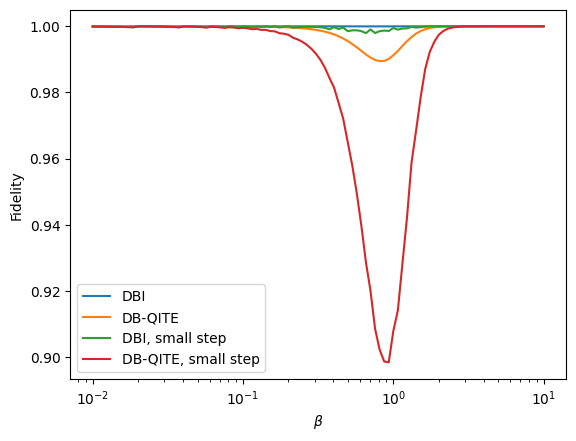

In [139]:
plt.figure()
plt.plot(beta, fidelityDBI_defaultStep, label='DBI')
plt.plot(beta, fidelityDBQITE_defaultStep, label='DB-QITE')
# plt.plot(beta, fidelityDBQITE_thirdOrder_defaultStep, label='DB-QITE-3')
plt.plot(beta, fidelityDBI_smallStep, label='DBI, small step')
plt.plot(beta, fidelityDBQITE_smallStep, label='DB-QITE, small step')
# plt.plot(beta, fidelityDBQITE_thirdOrder_smallStep, label='DB-QITE-3, small step')
plt.ylabel('Fidelity')
plt.xlabel(r'$\beta$')
plt.xscale('log')
plt.legend()
plt.show()
